# Тестовое задание: графовые базы данных
[задание ](https://trello.com/c/UsJ2qEVz/78-%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-7-%D0%B3%D1%80%D0%B0%D1%84%D0%BE%D0%B2%D1%8B%D0%B5-%D0%B1%D0%B0%D0%B7%D1%8B)


Задание выполняется с использованием БД neor4j (community)

Устанавливаю библиотеку neo4j
Подключаю БД к ноутбуку

In [6]:
from neo4j import GraphDatabase

In [7]:
class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        if self.driver is not None:
            self.driver.close()

# Метод, который передает запрос в БД
    def query(self, query, db=None):
        assert self.driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self.driver.session(database=db) if db is not None else self.driver.session()
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

После этого можно работать с БД, отправляя запросы при помощи выше примененного метода или напрямую из браузера neo4j

### Загрузка данных

Загружаю (напрямую запросами из браузера)
События (Events) и Участников (Person)
LOAD CSV WITH HEADERS FROM "file:///data_test_s.csv" AS row FIELDTERMINATOR ';'
MERGE (:Event {eventID: row.id})
MERGE(:Person{name:row.name1})
MERGE(:Person{name:row.name2})
;

Загружаю связи [:Partisipant] 
LOAD CSV WITH HEADERS FROM "file:///data_test_s.csv" AS row FIELDTERMINATOR ';'
    MATCH (p1:Person{name:row.name1})
    MATCH (e1:Event{eventID:row.id})
    MERGE (p1)-[:Partisiprnt{number:1}]->(e1)

LOAD CSV WITH HEADERS FROM "file:///data_test_s.csv" AS row FIELDTERMINATOR ';'   
    MATCH (p2:Person{name:row.name2})
    MATCH (e2:Event{eventID:row.id})
    MERGE (p2)-[:Partisiprnt{number:2}]->(e2)

### Запрос численных параметров :
Количество узлов Person
Количество узлов Event
Количество ребер

In [35]:
with GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", "qweRTY123")) as driver:
    driver.verify_connectivity()
    with driver.session() as session:
        persons = session.run("Match (n:Person) RETURN Count (n)").value()[0]
        events= session.run("Match (n:Event) RETURN Count (n)").value()[0]
        links = session.run("Match ()-[r]->() RETURN Count (r)").value()[0]
        
print ('persons = ', persons, 'events=' ,events ,'links =', links)
nodes= persons + events
print ('Graph Density = ', 2*links/(nodes*(nodes-1)))


persons =  9899 events= 4985 links = 10000
Graph Density =  9.028588356916638e-05


Видим, что граф является сильно разреженным, поэтому имеет смысл отобрать из него только нетривиальные узлы.

### Отбор нетривиальных узлов

Выберем участников, которые участвовали более, чем в одном мероприятии

MATCH (p:Person)
WHERE COUNT{(p)-[l:Partisiprnt]->(e:Event)}>1
RETURN p ;

Таких оказалось 27

Выберем мероприятия, в которых участвовало более двух человек

MATCH (e:Event)
WHERE COUNT{(p:Person)-[l:Partisiprnt]->(e:Event)}>2
RETURN e ;

Таких оказалось 15.

Теперь выберем сразу и участников и события из двух предыдущих запросов, а так же все узлы (события или участники), которые с ними связаны.

Match (p:Person | Event)
Where Count{ (p)-[:Partisiprnt]->(:Event)} >1 or Count {(p)-[:Partisiprnt]-(:Person)}>2
Match (a:Person | Event) --(p)
return p,a



### Визуальный анализ
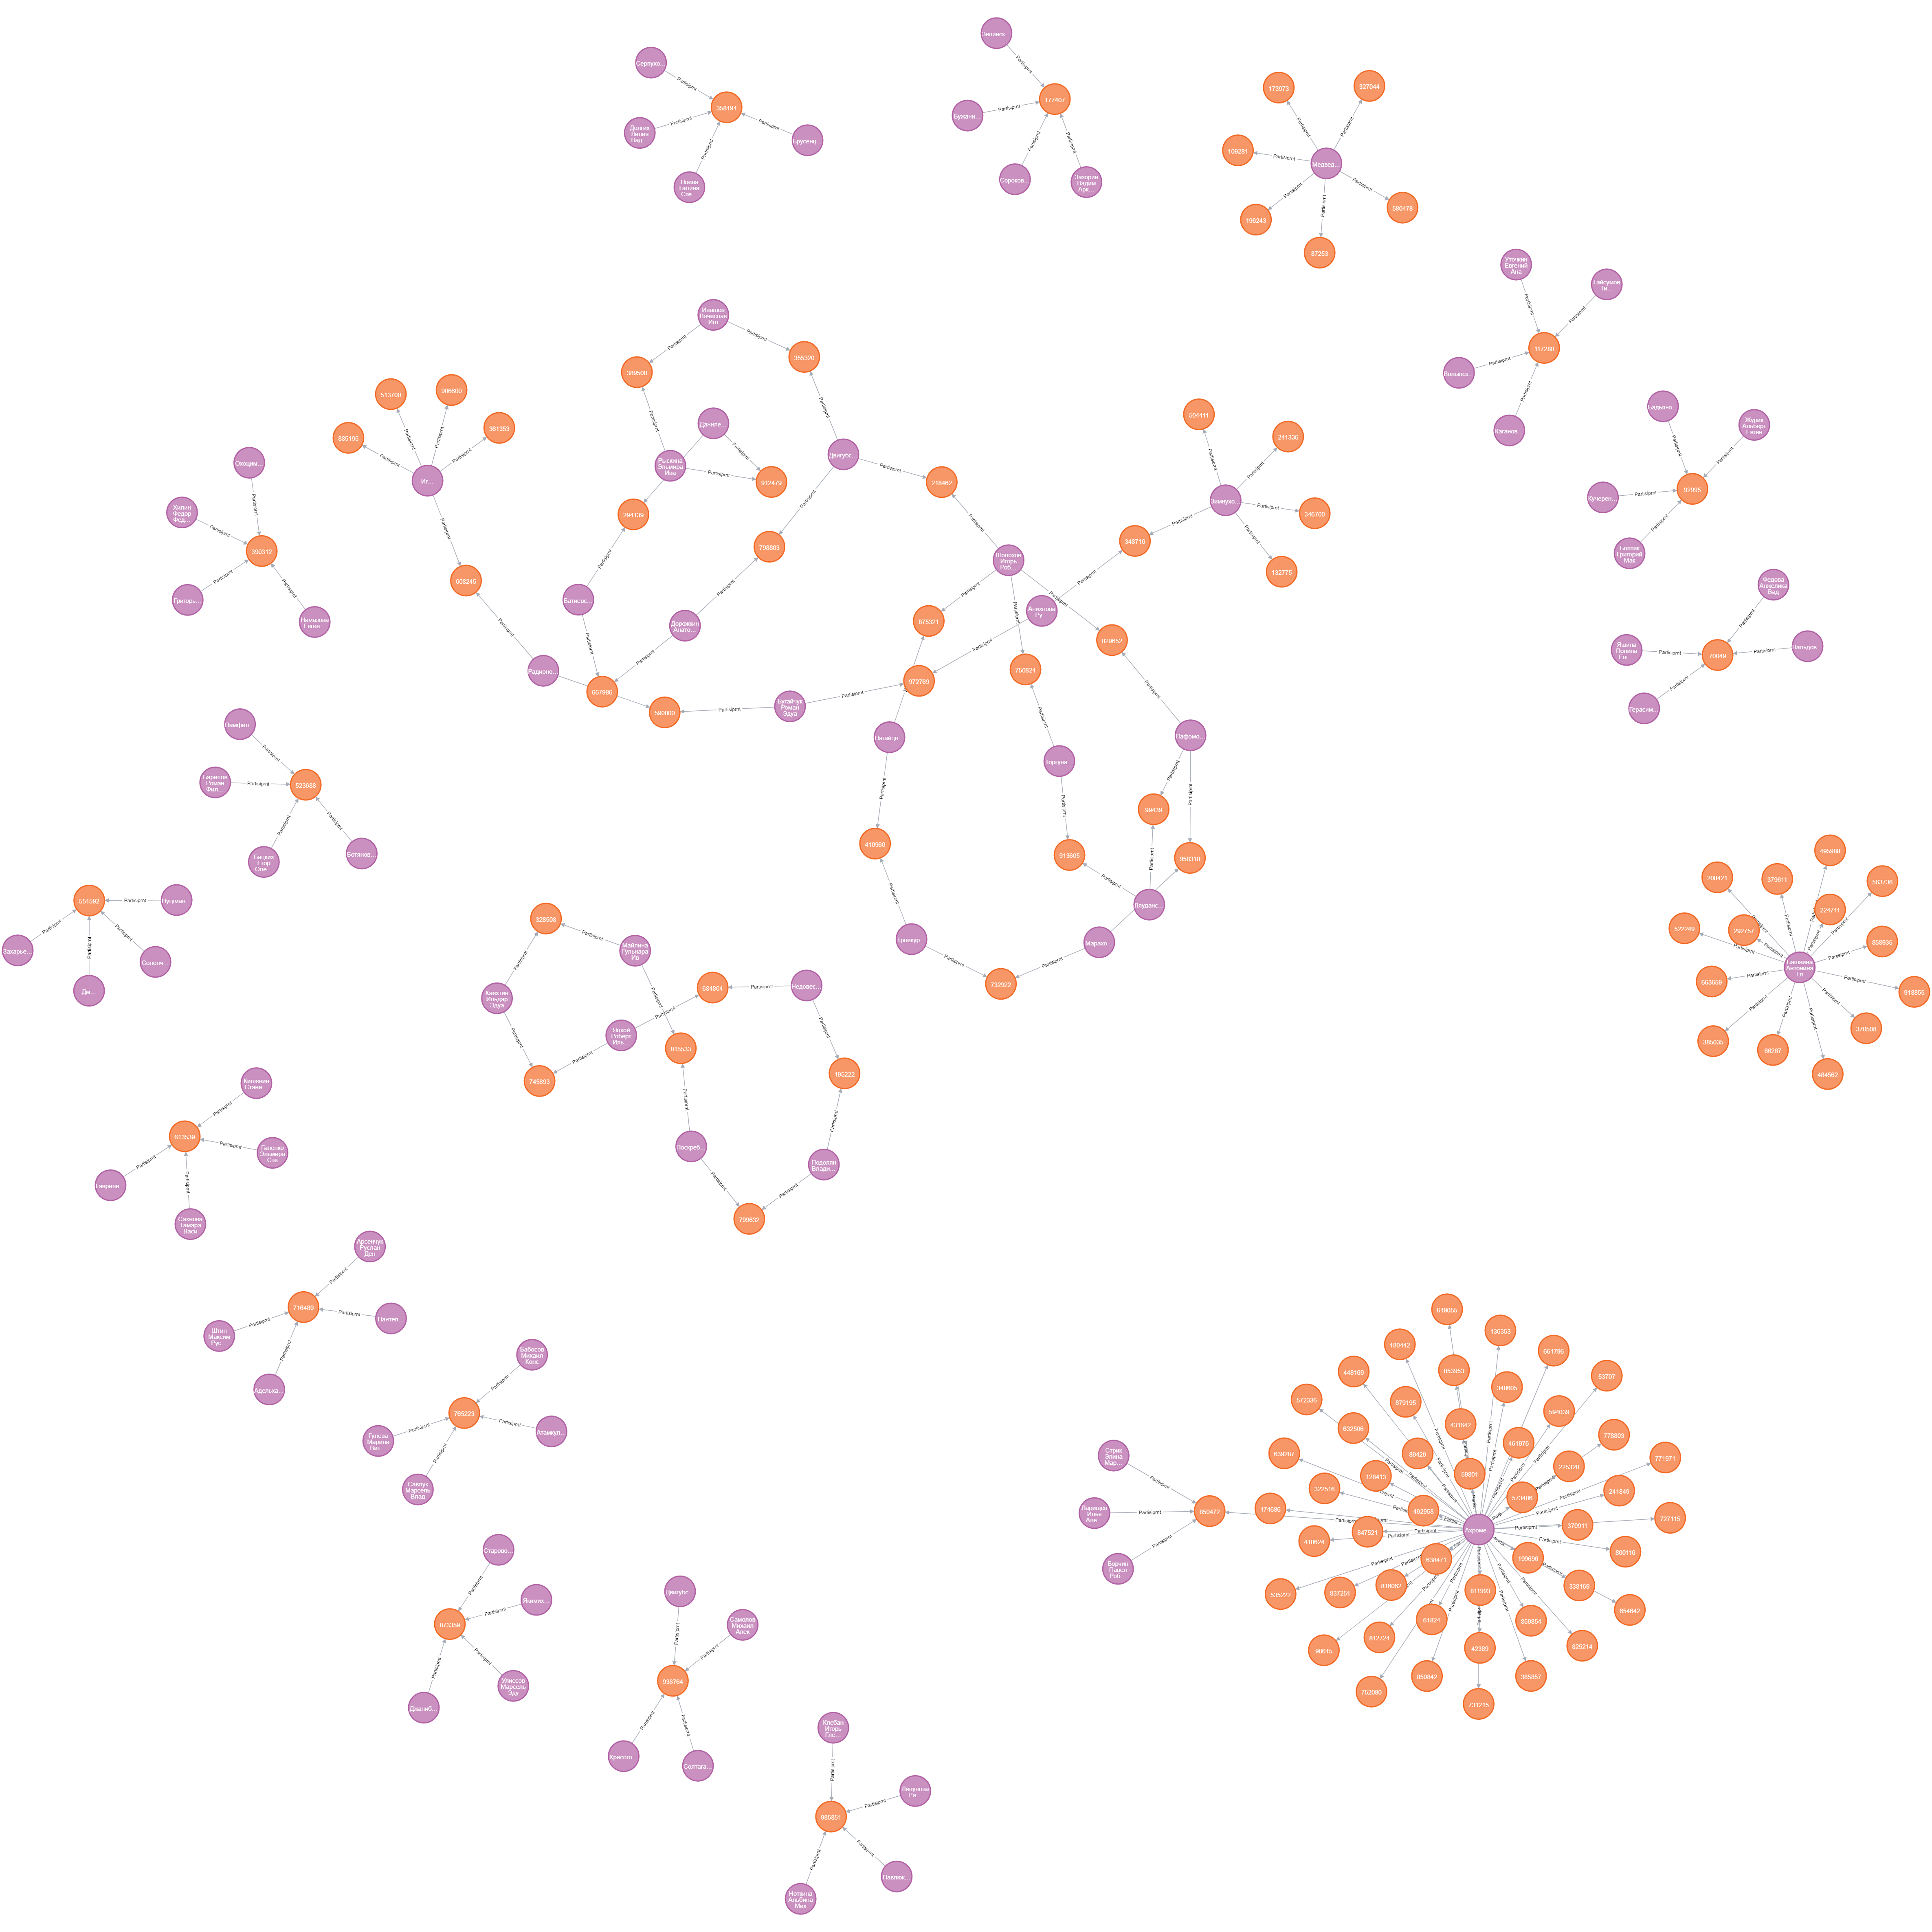


Все остальные данные, не вошедшие в эту картинку, представляют собой простые изолированные элементы, состоящие из одного события и не более двух участников

Визуально выделяются несколько изолированных фрагментов:
1. Многосвязный граф в верхней части 
2. два односвязных графа с большим количеством связей (мероприятий), относящихся к одному человеку.


Вывод, который можно сделать: Разные люди посещают разные мероприятия, т.е. длинных связанных фрагментов нет. Мероприятий с числом участников более 4 нет
    
Вцелом это иллюстрирует идею "механизма предпочтительного соединения" - узел, имеющий большее количество связей с большей вероятностью обзаводится новыми связями.

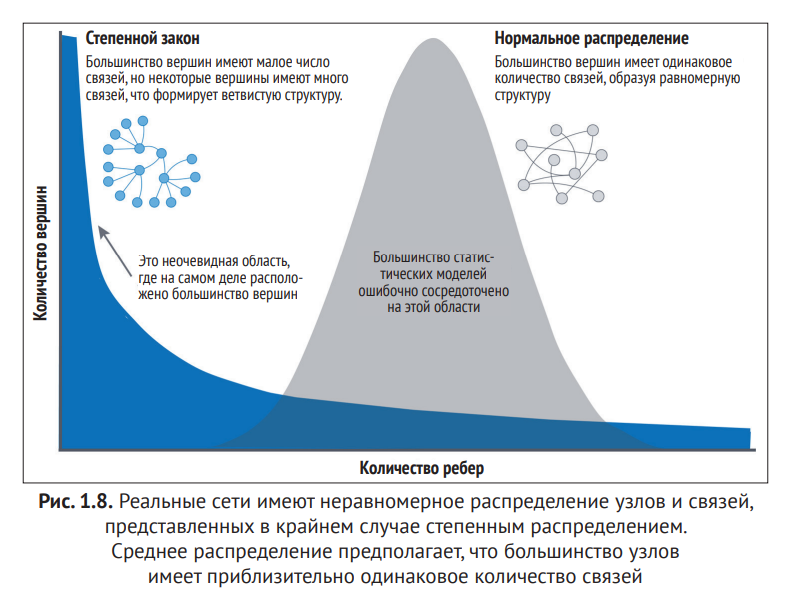

### REST сервис

В задании требуется написать REST сервис на python ввод: ФИО вывод: граф в формате graphml или json.

На данном этапе сервис я не написал, если это необходимо, то мне потребуется дополнительное время. 

В neo4j существует возможность экспорта в формате JSON или GRAPHML:

CALL apoc.export.json.query("MATCH p= (n:Person)-[]-(), WHERE n.name CONTAINS "Мингажетдинов",RETURN p")